In [28]:
# Reproducing https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2049046/ (On the evolutionary origin of aging)

Есть клетки <br>
В клетках есть уровень поломок d<br>
За время жизни клетка накапливает уровень поломок k<br>
При делении в одну дочернюю клетку идет (1+a)(d+k)/2 урона, а в другую (1-a)(d+k)/2 (a - уровень асимметрии, от 0 до 1) <br>

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tqdm.notebook import tqdm

%matplotlib notebook 

<IPython.core.display.Javascript object>


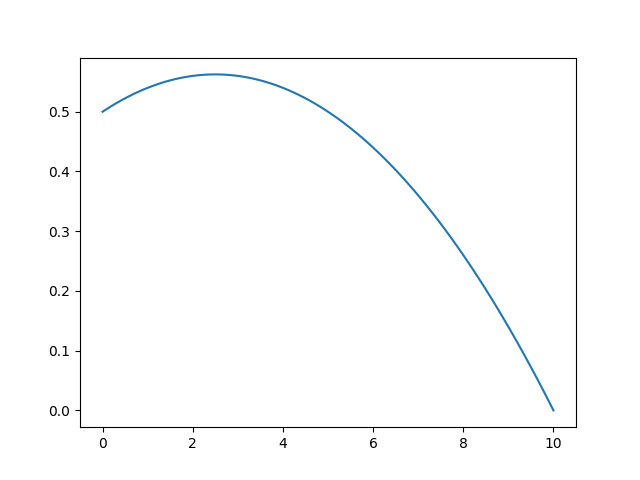

In [3]:
def damage_to_fitness(d, d0=10, r=0, r0=10, c=1):
    return (1 - c * (d/d0) - (1 - c)*(d/d0)**4)*(1-r/r0)

def damage_to_fitness(d, d0=10, r=0, r0=10):
    return (1 - d/d0)*(1-r/r0)



k = 5
xx = np.linspace(0, 10, 100)
yy = [damage_to_fitness(k-r, r=r) for r in xx]
plt.plot(xx, yy)

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from tqdm.notebook import tqdm

%matplotlib notebook 

def damage_to_fitness(d, d0=10, r=0, r0=10, c=1):
    return (1 - c * (d/d0) - (1 - c)*(d/d0)**4)*(1-r/r0)


class History:
    def __init__(self, simulation):
        self.simulation = simulation
        self.asymmetric_proportion = []
        self.population_size = []
        self.population_size_increment = []
        self.asymmetry_dist = []
        self.repair_dist = []
        
        
    def record(self):
        n_symmetric = len(list(filter(lambda cell: cell.a == 0, self.simulation.cells)))
        n_asymmetric = len(list(filter(lambda cell: cell.a > 0, self.simulation.cells)))
        self.asymmetric_proportion.append(n_asymmetric/(n_symmetric+n_asymmetric))
        
        self.population_size.append(len(self.simulation.cells))
        if len(self.population_size) > 1:
            self.population_size_increment.append(self.population_size[-1]/self.population_size[-2])
        
        self.asymmetry_dist.append([cell.a for cell in self.simulation.cells])
        self.repair_dist.append([cell.r for cell in self.simulation.cells])
        
            
    def setup_figure(self, mode="asymmetric proportion"):
        if mode == "asymmetric proportion":
            self.figure, self.axis = plt.subplots()
            plt.ion()
            self.asymmetric_proportion_line, = self.axis.plot([], [])
        elif mode == "distributions":
            self.figure, self.axis = plt.subplots(1, 2)
            plt.ion()
            self.a_dist_bars = self.axis[0].bar(np.linspace(0, 1, 10), [1]*10)
            self.r_dist_bars = self.axis[1].bar(np.linspace(0, 1, 10), [1]*10)
        else:
            print(f"Unknown draw mode: {mode}")
    
    def draw(self, mode="asymmetric proportion"):
        if mode == "asymmetric proportion":
            self.asymmetric_proportion_line.set_xdata(range(len(self.asymmetric_proportion)))
            self.asymmetric_proportion_line.set_ydata(self.asymmetric_proportion)
            self.figure.canvas.draw()
            self.figure.canvas.flush_events()
            self.axis.set_xlim(0, len(self.asymmetric_proportion))
            self.axis.set_ylim(0, 1.1)
            self.axis.set_ylabel('% of asymmetric')
    

class Simulation:
    def __init__(self, 
                 starting_popsize, asymmetric_proportion, 
                 k, c,
                 starting_damage=0, 
                 a=1,
                 r=0):
        n_symmetric = round(starting_popsize*(1-asymmetric_proportion))
        n_asymmetric = starting_popsize - n_symmetric
        self.cells = [Cell(d=starting_damage, 
                           a=0, 
                           r=r, 
                           c=c) for _ in range(n_symmetric)] + [Cell(d=starting_damage, 
                                                                     a=a, 
                                                                     r=r, 
                                                                     c=c) for _ in range(n_asymmetric)]
        
        self.history = History(self)
        self.k = k
                
    def step(self, max_popsize):
        # If we control population size, ajust fitnesses so that expected number of cells in the next generation
        # does not exceed the max_populatin size
        if max_popsize:
            expected_progeny = sum([cell.fitness for cell in self.cells])*2
            coef = max_popsize/expected_progeny
            for cell in self.cells:
                cell.fitness *= coef
        
        # Cells live and accumulate damage
        for cell in self.cells:
            cell.live(self.k)
    
        # Cells die because of accumulated damage
        self.cells = list(filter(lambda cell: cell.alive, self.cells))
        
        
        # Cells reproduce
        new_generation = []
        for cell in self.cells:
            new_generation += cell.divide()
        self.cells = new_generation

        # Record history
        self.history.record()
                    
    @property
    def stable(self):
        return len(self.history.population_size_increment) > 1 and round(self.history.population_size_increment[-1], 2) == round(self.history.population_size_increment[-2], 2)
        
    def run(self, mode, n_steps=None, max_popsize=None, plot=False):
        """
        mode is one of ['growth rate', 'competition']
        """
        if mode == "growth rate":
            while not self.stable:
                self.step(max_popsize=max_popsize)
            return self.history.population_size_increment[-1]
        elif mode == "competition":
            if plot:
                self.history.setup_figure()
            for _ in range(n_steps):
                self.step(max_popsize=max_popsize)
                if plot:
                    self.history.draw()
        else:
            print(f"Unknown mode: {mode}")
        
        

    
            
            
class Cell:
    def __init__(self, d, a, r, c, m=0, sigma_a=0.01, sigma_r=0.05):
        self.damage = d # amount of damage
        self.a = a # assymetry of division
        self.r = r # repair intencity
        self.c = c # linearity of dependence of fitness on the amount of damage
        self.fitness = damage_to_fitness(d=d, r=r, c=c) # survival probability
        self.alive = True # indicator if cell have died because of damage
        
        self.mutation_rate = m # probability to mutate a or r
        self.sigma_a = sigma_a # paramteter of normal distribution of a mutation
        self.sigma_r = sigma_r # paramteter of normal distribution of r mutation
        
    def live(self, k):
        self.damage += k # accumulate damage
        self.fitness = max(self.fitness, 0) # don't get negative fitness
        self.alive = np.random.choice([True, False], p=[self.fitness, 1-self.fitness]) # die or stay alive
        
        
    def divide(self):
        
        # Mutation
        aa = [self.a]*2
        rr = [self.r]*2
        for i in range(2):
            if np.random.uniform(0, 1) < self.mutation_rate:
                aa[i] += np.random.normal(0, self.sigma_a)
                aa[i] = min(min(aa[i], 1), -1)
            if np.random.uniform(0, 1) < self.mutation_rate:
                rr[i] += np.random.normal(0, self.sigma_r)
                rr[i] = min(min(rr[i], 1), -1)
        
        # Division
        daughter_cells = [Cell(self.damage*(1+self.a)/2, aa[0], rr[0], self.c), 
                          Cell(self.damage*(1-self.a)/2, aa[0], rr[1], self.c)]
        return daughter_cells
        

<IPython.core.display.Javascript object>


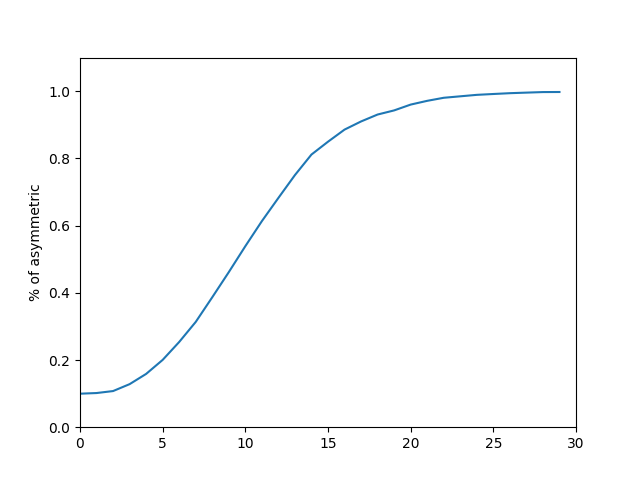

In [12]:
# Asymmetrically dividing cells take over with linear fitness dependence on cell damage

my_simulation = Simulation(starting_popsize=10000, 
                           asymmetric_proportion=0.1, k=5, c=1, 
                           starting_damage=0)
my_simulation.run(mode="competition", n_steps=30, max_popsize=10000, plot=True)

<IPython.core.display.Javascript object>


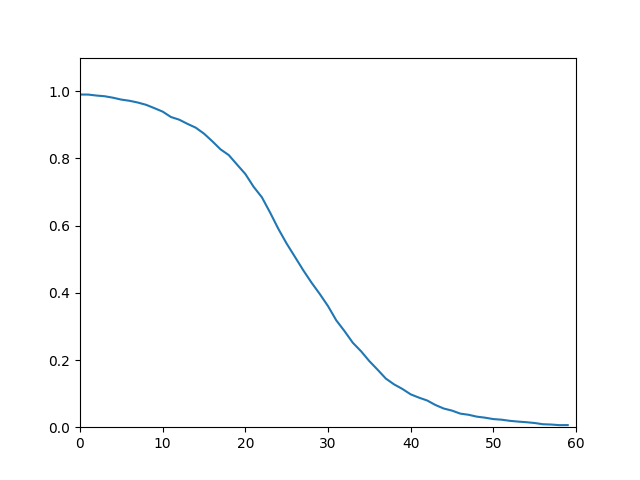

In [8]:
# But they lose with concave dependence of fitness on damage 

my_simulation = Simulation(starting_popsize=10000, 
                           asymmetric_proportion=0.99, k=5, c=0,
                           starting_damage=0)
my_simulation.run(mode="competition", n_steps=60, max_popsize=10000, plot=True)

In [9]:
# Calculating fintesses of different symmetry types with different damage accumulation modes

aa = np.linspace(0, 1, 6)
cc = np.linspace(0, 1, 6)
ff = []
for c in tqdm(cc):
    ff.append([])
    for a in tqdm(aa): 
        my_simulation = Simulation(starting_popsize=1000, 
                                   asymmetric_proportion=1, k=5, c=c, 
                                   starting_damage=0, a=a)
        f = my_simulation.run(mode="growth rate")
        ff[-1].append(f)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


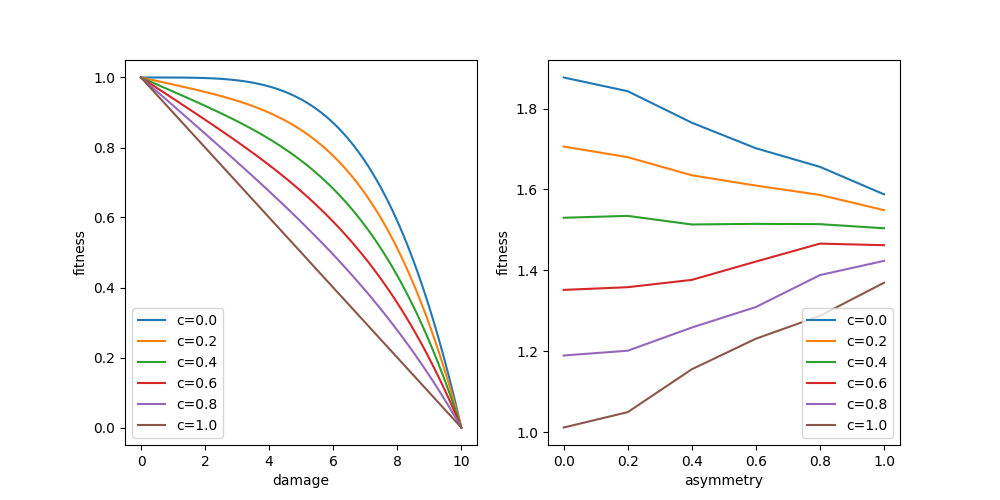

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
dd = np.linspace(0, 10, 100)
for i, c in enumerate(cc):
    ax[0].plot(dd, [damage_to_fitness(d, d0=10, c=c) for d in dd], label='c='+str(round(c, 1)))
    ax[0].set_xlabel("damage")
    ax[0].set_ylabel("fitness")
    ax[1].plot(aa, ff[i], label="c="+str(round(c, 1)))
    ax[1].set_xlabel("asymmetry")
    ax[1].set_ylabel("fitness")
ax[0].legend()
ax[1].legend()

plt.show()